In [1]:
import boto3
import pandas as pd
import numpy as np
import logging
from io import StringIO
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from pycytominer import annotate
import plotly.io as pio
import os


def read_csv_from_s3(bucket_name, key):
    """
    Reads a CSV file from S3 and returns it as a pandas DataFrame.

    Parameters:
        bucket_name (str): Name of the S3 bucket
        key (str): Full path to the CSV file in the bucket

    Returns:
        pd.DataFrame: Loaded DataFrame
    """
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket_name, Key=key)
    
    csv_content = response['Body'].read().decode('utf-8')
    df = pd.read_csv(StringIO(csv_content))
    
    return df


In [3]:

areas={}
for time in ['24h','48h']:
    for dset in ['NL150-1000','NL150-2000']:
        filtered_plateMap = read_csv_from_s3(f"cellprofiler-resuts", f'IRIC/CellSeedingDensity_1000VS2000_202505/{dset}_PlateMap.csv')
        filtered_plateMap = filtered_plateMap[['Metadata_Compound', 'Metadata_ConcLevel', 'Metadata_Well', 'Metadata_Plate']]# plate map 
        filtered_plateMap["Metadata_Compound"] = filtered_plateMap["Metadata_Compound"].apply(lambda x: str(x).upper())

        df = read_csv_from_s3("cellprofiler-resuts", f'IRIC/CellSeedingDensity_1000VS2000_202505/{dset}/{time}/Cells.csv')

        df_ann = annotate(df, filtered_plateMap, join_on=[["Metadata_Well"], ["Metadata_Well"]])
        df_grouped = (
            df_ann[df_ann["Metadata_Compound"] == "DMSO"].groupby("ImageNumber")["AreaShape_Area"]
            .agg(lambda x: (x.sum() / 4_000_000)*100)
            .reset_index(name="AreaShape_Area_scaled")
        )
        areas[dset+'_'+time]=df_grouped.AreaShape_Area_scaled.values


In [ ]:
df_ann[df_ann["Metadata_Compound"] == "DMSO"].groupby("ImageNumber")["AreaShape_Area"]

,Metadata_Compound,Metadata_ConcLevel_platemap,Metadata_Well,Metadata_Plate_platemap,Metadata_ConcLevel,Metadata_Plate,Metadata_Site,Metadata_Timepoint,ImageNumber,ObjectNumber,...,Texture_Variance_DNA_20_02_256,Texture_Variance_DNA_20_03_256,Texture_Variance_DNA_3_00_256,Texture_Variance_DNA_3_01_256,Texture_Variance_DNA_3_02_256,Texture_Variance_DNA_3_03_256,Texture_Variance_DNA_5_00_256,Texture_Variance_DNA_5_01_256,Texture_Variance_DNA_5_02_256,Texture_Variance_DNA_5_03_256
0,SP0075,1,B10,NL150-2000,1,NL150_2000,1,48,33,1,...,11.696701,11.604452,11.525278,11.558334,11.541132,11.624822,11.636427,11.715808,11.631878,11.743029
1,SP0075,1,B10,NL150-2000,1,NL150_2000,1,48,33,2,...,8.186638,9.115189,7.669689,7.676785,7.617525,7.724417,7.779891,7.766751,7.703107,7.875523
2,SP0075,1,B10,NL150-2000,1,NL150_2000,1,48,33,3,...,2.836517,2.505447,2.531094,2.561746,2.535276,2.565842,2.583283,2.624444,2.590512,2.632512
3,SP0075,1,B10,NL150-2000,1,NL150_2000,1,48,33,4,...,11.124391,11.138588,10.092538,10.183851,10.145447,10.158628,10.172925,10.329993,10.249474,10.281342
4,SP0075,1,B10,NL150-2000,1,NL150_2000,1,48,33,5,...,3.108549,3.078272,3.025131,3.002474,3.008457,3.017705,3.021613,2.999855,3.002193,3.016824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68620,SP0082,1,O22,NL150-2000,1,NL150_2000,4,48,1228,94,...,3.660142,3.945927,3.178032,3.244500,3.232015,3.247881,3.226058,3.326554,3.299542,3.315691
68621,SP0082,1,O22,NL150-2000,1,NL150_2000,4,48,1228,95,...,2.656113,2.454166,2.389120,2.423068,2.405121,2.459911,2.449524,2.499790,2.473740,2.558484
68622,SP0082,1,O22,NL150-2000,1,NL150_2000,4,48,1228,96,...,9.574345,11.482705,14.994610,14.637753,14.697066,14.841017,14.820484,14.620265,14.432114,14.357482
68623,SP0082,1,O22,NL150-2000,1,NL150_2000,4,48,1228,97,...,6.899836,6.206245,6.021121,6.153034,6.112304,6.124390,6.020040,6.273863,6.226916,6.206871


In [4]:
df_plot=pd.DataFrame(areas)

/var/folders/29/zln5sc99789bcrjd_jmpj0f00000gn/T/ipykernel_4954/2269820885.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x="Feature", y="Value", data=df_melted, inner=None,palette=palette )


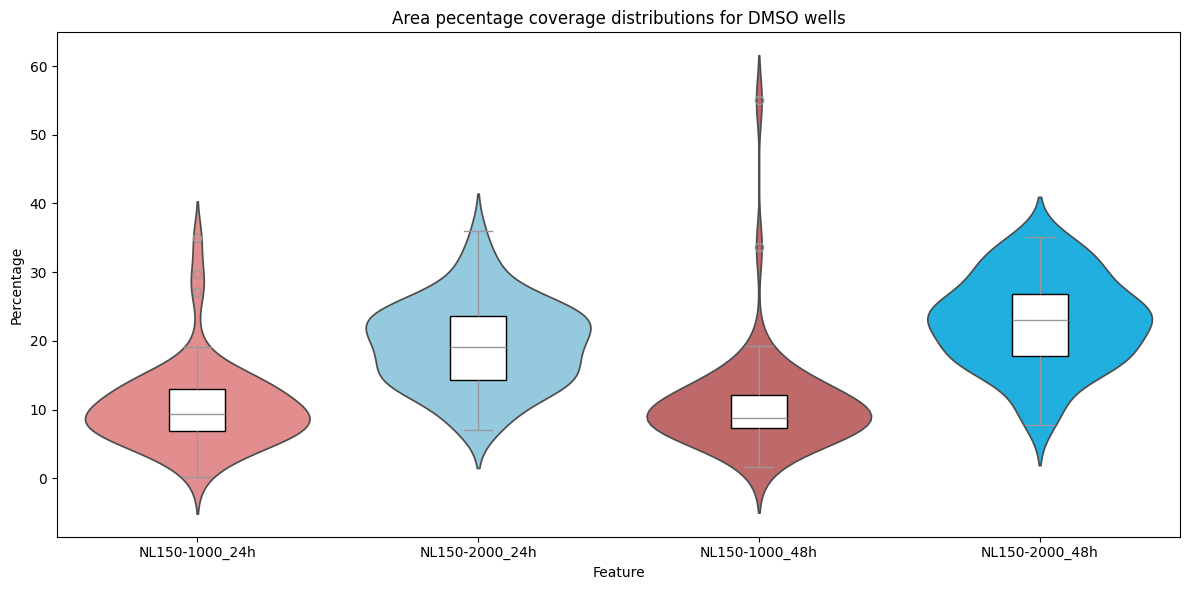

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with 4 numeric columns
df_melted = df_plot.melt(var_name="Feature", value_name="Value")

palette = ['lightcoral', 'skyblue', 'indianred', 'deepskyblue']
# Plot
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Feature", y="Value", data=df_melted, inner=None,palette=palette )
sns.boxplot(x="Feature", y="Value", data=df_melted, width=0.2, color="white", boxprops={"edgecolor": "black"})


plt.title("Area pecentage coverage distributions for DMSO wells")
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import pingouin as pg
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_mdc(df, alpha=0.05, use_pca=False, n_components=None):
    """
    Calculate Mahalanobis Distance Consistency metrics and return distances.
    
    Parameters:
    - df: DataFrame with features
    - alpha: significance level for chi2 threshold (default=0.05)
    - use_pca: whether to apply PCA before computing distances (default=False)
    - n_components: number of PCA components (default=None = all components)
    
    Returns:
    - metrics: dict with distance stats
    - dists_sq: array of squared Mahalanobis distances
    - is_outlier: boolean array where True means outlier
    """
    df = df.loc[:, df.std() > 1e-10]  # Remove near-constant columns

    if use_pca:
        pca = PCA(n_components=n_components)
        X = pca.fit_transform(df.values)
        pca_df = pd.DataFrame(X, columns=[f'PC{i+1}' for i in range(X.shape[1])], index=df.index)

        # Explained variance ratio
        explained_var = pca.explained_variance_ratio_

        # Plot the first two PCs
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='PC1', y='PC2', data=pca_df)
        for i, label in enumerate(pca_df.index):
            plt.text(pca_df.PC1[i], pca_df.PC2[i], label, fontsize=8, alpha=0.7)
        plt.title('PCA of DMSO Replicates')
        plt.xlabel(f'PC1 ({explained_var[0]*100:.1f}% variance)')
        plt.ylabel(f'PC2 ({explained_var[1]*100:.1f}% variance)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
                
    else:
        X = df.values

    mu = X.mean(axis=0)
    cov = np.cov(X, rowvar=False)

    try:
        inv_cov = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        inv_cov = np.linalg.pinv(cov)

    dists_sq = np.sum((X - mu) @ inv_cov * (X - mu), axis=1)

    dof = X.shape[1]
    chi2_thresh = chi2.ppf(1 - alpha, dof)
    is_outlier = dists_sq > chi2_thresh

    metrics = {
        'mean_distance': np.mean(dists_sq),
        'distance_cv': np.std(dists_sq) / np.mean(dists_sq),
        '95th_percentile': np.percentile(dists_sq, 95),
        'chi2_threshold': chi2_thresh,
        'outlier_ratio': np.mean(is_outlier)
    }

    return metrics, dists_sq, is_outlier


def plot_mahalanobis_distances(distances, is_outlier, threshold, index_labels):
    plt.figure(figsize=(14, 6))
    plt.title("Squared Mahalanobis Distances with Outliers")

    # Plot all distances
    plt.plot(distances, marker='o', linestyle='-', label='Distance²')

    # Highlight and label outliers
    for i, (dist, is_out, label) in enumerate(zip(distances, is_outlier, index_labels)):
        if is_out:
            plt.scatter(i, dist, color='red', zorder=5)
            plt.text(i, dist, str(label), color='black', fontsize=8, ha='right', rotation=45)

    # Threshold line
    plt.axhline(y=threshold, color='orange', linestyle='--', label=f'Chi² Threshold ({threshold:.2f})')

    plt.xlabel("Sample Index")
    plt.ylabel("Mahalanobis Distance²")
    plt.legend()
    plt.tight_layout()
    plt.show()



exp1=pd.read_csv('/Users/dcamacho/Downloads/CQDM_CTL_Plates_CP_features_selected_allTimes_dSig_QC.csv')
exp1["Well_Plate"]= exp1.Metadata_Well + '_'+exp1.Metadata_Plate.astype(str)
well_bl={}
for time in exp1.Metadata_Timepoint.unique():
    dmso_features=exp1[(exp1.Metadata_Compound=='DMSO')& (exp1.Metadata_Timepoint==time)]
    X=dmso_features.set_index('Well_Plate').select_dtypes(include=np.number)
    metrics, distances, is_outlier = calculate_mdc(X, alpha=0.05,use_pca=True, n_components=.90)
    plot_mahalanobis_distances(distances, is_outlier, metrics['chi2_threshold'], X.index)
    well_bl[time]=dmso_features.Well_Plate[is_outlier]

In [29]:
rows=[]
for timepoint, series in well_bl.items():
    for idx, well_plate in series.items():
        rows.append({'Timepoint': timepoint, 'Index': idx, 'Well_Plate': well_plate})

# Convert to DataFrame
df_blacklist = pd.DataFrame(rows)

# Save to CSV
df_blacklist.to_csv("/Users/dcamacho/Documents/Pfizer_Josiane/QCDM/CTL_plate_DMSO_bl.csv", index=False)


In [ ]:
# Set up S3 client
s3 = boto3.client('s3')
bucket_name = "cellprofiler-resuts"
base_folder_path = f"workspacePfizer-Exp4_5"
# List of kit identifiers (folder names in S3) and friendly labels


times = ["GCOE24010961",
"GCOE24010962",
"GCOE24010963",
"GCOE24010964",
"GCOE24010965",
"GCOE24010966",
"GCOE24003446",
"GCOE24003447",
"GCOE24003448",
"GCOE24003449",
"GCOE24003450",
"GCOE24003451"]
output_folder=f'/Users/dcamacho/Documents/PfizerData/HIPS_QC'

os.makedirs(output_folder, exist_ok=True)

# QC Feature settings
feature_groups = {
    'ImageQuality_Power': {'color': 'orange', 'threshold': 'iqr'},
    'ImageQuality_PercentMax': {'color': 'blue', 'threshold': 'fixed', 'fixed_thresh': 0.001},
    'Count_Nuclei': {'color': 'red','threshold': 'iqr'},
    'Count_Nuclei_DMSO':{'color':'lightblue'}
}



for time in times:
    filtered_plateMap = read_csv_from_s3(f"cellprofiler-resuts", f'workspacePfizer-Exp4_5/Plate_{time}_PlateMap.csv')
    filtered_plateMap = filtered_plateMap[['Metadata_Compound', 'Metadata_ConcLevel', 'Metadata_Well', 'Metadata_Plate']]# plate map 
    filtered_plateMap["Metadata_Compound"] = filtered_plateMap["Metadata_Compound"].apply(lambda x: str(x).upper())
    DMSO_wells=filtered_plateMap[filtered_plateMap["Metadata_Compound"] == "DMSO"]['Metadata_Well'].values
    print(f"📦 Processing kit: {time}")
    try:
        features_key = f"{base_folder_path}/Plate_{time}/Image.csv"
        df = read_csv_from_s3(bucket_name, features_key)
        print(f"✅ Loaded {features_key}")
        
    except Exception as e:
        print(f"❌ Error: {e}")
        continue

    all_traces = []
    all_titles = []

    for group_prefix, settings in feature_groups.items():
        if group_prefix == 'Count_Nuclei_DMSO':
            # Special case: this is not a real column — it's filtered Count_Nuclei
            mask = (df['Metadata_Well'].isin(DMSO_wells)) & (df['Count_Nuclei'].notna())
            values = df.loc[mask, 'Count_Nuclei'].dropna()
            wells = df.loc[mask, 'Metadata_Well']
            site = df.loc[mask, 'Metadata_Site'].astype(str)

            # You can apply QC thresholds if desired, or skip
            lower_thresh = None
            upper_thresh = None

            # Plot
            histogram = go.Histogram(
                x=values,
                nbinsx=len(DMSO_wells),
                marker_color=settings['color'],
                opacity=0.5,
                showlegend=False
            )
            all_traces.append([histogram])

            scatter = go.Scatter(
                x=values,
                y=[0.1] * len(values),
                mode='markers',
                marker=dict(color='lightgrey'),
                customdata=np.stack([wells + '_S' + site], axis=-1),
                hovertemplate="Well: %{customdata[0]}<br>Value: %{x:.2f}<extra></extra>",
                showlegend=False
            )
            all_traces[-1].append(scatter)

            all_titles.append(f"Count_Nuclei (DMSO only) / {time}")

        else:
            # Standard case: use all columns that match the group prefix
            matching_columns = [col for col in df.columns if col.startswith(group_prefix)]
            for feature_col in matching_columns:
                values = df[feature_col].dropna()
                wells = df.loc[values.index, 'Metadata_Well']
                site = df.loc[values.index, 'Metadata_Site'].astype(str)

                # Threshold logic
                if 'threshold' in settings:
                    if settings['threshold'] == 'iqr':
                        Q1 = values.quantile(0.25)
                        Q3 = values.quantile(0.75)
                        IQR = Q3 - Q1
                        lower_thresh = Q1 - 1.5 * IQR
                        upper_thresh = Q3 + 1.5 * IQR
                        fail_mask = (df[feature_col] < lower_thresh) | (df[feature_col] > upper_thresh)
                    else:
                        lower_thresh = settings['fixed_thresh']
                        upper_thresh = None
                        fail_mask = df[feature_col] >= lower_thresh

                    # Save QC column
                    qc_col = f"ImageQC_{feature_col}"
                    df[qc_col] = fail_mask.where(~df[feature_col].isna(), np.nan)

                # Plot
                histogram = go.Histogram(
                    x=values,
                    nbinsx=100,
                    marker_color=settings['color'],
                    opacity=0.5,
                    showlegend=False
                )
                all_traces.append([histogram])

                scatter = go.Scatter(
                    x=values,
                    y=[0.1] * len(values),
                    mode='markers',
                    marker=dict(color='lightgrey'),
                    customdata=np.stack([wells + '_S' + site], axis=-1),
                    hovertemplate="Well: %{customdata[0]}<br>Value: %{x:.2f}<extra></extra>",
                    showlegend=False
                )
                all_traces[-1].append(scatter)

                if upper_thresh is not None:
                    all_traces[-1].append(go.Scatter(
                        x=[upper_thresh, upper_thresh],
                        y=[0, 100],
                        mode='lines',
                        line=dict(color='red', width=2, dash='dot'),
                        name='Upper Threshold',
                        showlegend=False
                    ))
                if lower_thresh is not None and group_prefix != 'ImageQuality_PercentMax':
                    all_traces[-1].append(go.Scatter(
                        x=[lower_thresh, lower_thresh],
                        y=[0, 100],
                        mode='lines',
                        line=dict(color='red', width=2, dash='dot'),
                        name='Lower Threshold',
                        showlegend=False
                    ))

                all_titles.append(f"{feature_col} / {time}")

    # Create subplot
    fig = make_subplots(rows=len(all_traces), cols=1, subplot_titles=all_titles)
    for i, trace_group in enumerate(all_traces):
        for trace in trace_group:
            fig.add_trace(trace, row=i + 1, col=1)

    fig.update_layout(
        height=430 * len(all_traces),
        width=800,
        title_text=f"Feature Distributions with QC for {time}",
        template='simple_white',
        barmode='overlay'
    )

    # Save HTML
    html_path = f"{output_folder}/qc_plots_{time}.html"
    #pio.write_html(fig, file=html_path, auto_open=False)
    print(f"💾 HTML saved: {html_path}")

    # Save modified CSV to S3
    csv_buffer = StringIO()
    df.to_csv(csv_buffer, index=False)
    s3.put_object(
        Bucket=bucket_name,
        Key=features_key,
        Body=csv_buffer.getvalue()
    )
    print(f"✅ Updated CSV with QC columns uploaded: {features_key}")


📦 Processing kit: GCOE24010961
✅ Loaded workspacePfizer-Exp4_5/Plate_GCOE24010961/Image.csv
💾 HTML saved: /Users/dcamacho/Documents/PfizerData/HIPS_QC/qc_plots_GCOE24010961.html
✅ Updated CSV with QC columns uploaded: workspacePfizer-Exp4_5/Plate_GCOE24010961/Image.csv
📦 Processing kit: GCOE24010962
✅ Loaded workspacePfizer-Exp4_5/Plate_GCOE24010962/Image.csv
💾 HTML saved: /Users/dcamacho/Documents/PfizerData/HIPS_QC/qc_plots_GCOE24010962.html
✅ Updated CSV with QC columns uploaded: workspacePfizer-Exp4_5/Plate_GCOE24010962/Image.csv
📦 Processing kit: GCOE24010963
✅ Loaded workspacePfizer-Exp4_5/Plate_GCOE24010963/Image.csv
💾 HTML saved: /Users/dcamacho/Documents/PfizerData/HIPS_QC/qc_plots_GCOE24010963.html
✅ Updated CSV with QC columns uploaded: workspacePfizer-Exp4_5/Plate_GCOE24010963/Image.csv
📦 Processing kit: GCOE24010964
✅ Loaded workspacePfizer-Exp4_5/Plate_GCOE24010964/Image.csv
💾 HTML saved: /Users/dcamacho/Documents/PfizerData/HIPS_QC/qc_plots_GCOE24010964.html
✅ Updated CS

In [27]:
s3 = boto3.client('s3')
bucket_name = "cellprofiler-resuts"
exp='Plate_2'
base_folder_path = f"IRIC/CQDM_CTL_Plate_Validation_202501/{exp}"
# List of kit identifiers (folder names in S3) and friendly labels
times = ["6h", "12h", "24h_2", "48h_2", "72h_2"]
output_folder=f'/Users/dcamacho/Documents/Pfizer_Josiane/QCDM/Plate1_DMSO/'

os.makedirs(output_folder, exist_ok=True)
filtered_plateMap = read_csv_from_s3(f"cellprofiler-resuts", f'{base_folder_path}/{exp}_PlateMap.csv')
filtered_plateMap = filtered_plateMap[['Metadata_Compound', 'Metadata_ConcLevel', 'Metadata_Well', 'Metadata_Plate']]# plate map 
filtered_plateMap["Metadata_Compound"] = filtered_plateMap["Metadata_Compound"].apply(lambda x: str(x).upper())
DMSO_wells=filtered_plateMap[filtered_plateMap["Metadata_Compound"] == "DMSO"]['Metadata_Well'].values
# QC Feature settings
feature_groups = {
    'ImageQuality_Power': {'color': 'orange', 'threshold': 'iqr'},
    'ImageQuality_PercentMax': {'color': 'blue', 'threshold': 'fixed', 'fixed_thresh': 0.001},
    'Count_Nuclei': {'color': 'red','threshold': 'iqr'},
    'Count_Nuclei_DMSO':{'color':'lightblue'}
}

for time in times:
    print(f"📦 Processing kit: {time}")
    try:
        # Locate Image.csv
        response = s3.list_objects_v2(
            Bucket=bucket_name,
            Prefix=f"{base_folder_path}/{time}/",
            Delimiter='/'
        )
        matching_files = [
            obj['Key']
            for obj in response.get('Contents', [])
            if obj['Key'].endswith("Image.csv")
        ]
        if not matching_files:
            raise FileNotFoundError(f"No matching Image.csv found for {time}")

        features_key = matching_files[0]
        df = read_csv_from_s3(bucket_name, features_key)
        print(f"✅ Loaded {features_key}")
        
    except Exception as e:
        print(f"❌ Error: {e}")
        continue

    all_traces = []
    all_titles = []

    for group_prefix, settings in feature_groups.items():
        if group_prefix == 'Count_Nuclei_DMSO':
            # Special case: this is not a real column — it's filtered Count_Nuclei
            mask = (df['Metadata_Well'].isin(DMSO_wells)) & (df['Count_Nuclei'].notna())
            values = df.loc[mask, 'Count_Nuclei'].dropna()
            wells = df.loc[mask, 'Metadata_Well']
            site = df.loc[mask, 'Metadata_Site'].astype(str)

            # You can apply QC thresholds if desired, or skip
            lower_thresh = None
            upper_thresh = None

            # Plot
            histogram = go.Histogram(
                x=values,
                nbinsx=len(DMSO_wells),
                marker_color=settings['color'],
                opacity=0.5,
                showlegend=False
            )
            all_traces.append([histogram])

            scatter = go.Scatter(
                x=values,
                y=[0.1] * len(values),
                mode='markers',
                marker=dict(color='lightgrey'),
                customdata=np.stack([wells + '_S' + site], axis=-1),
                hovertemplate="Well: %{customdata[0]}<br>Value: %{x:.2f}<extra></extra>",
                showlegend=False
            )
            all_traces[-1].append(scatter)

            all_titles.append(f"Count_Nuclei (DMSO only) / {time}")

        else:
            # Standard case: use all columns that match the group prefix
            matching_columns = [col for col in df.columns if col.startswith(group_prefix)]
            for feature_col in matching_columns:
                values = df[feature_col].dropna()
                wells = df.loc[values.index, 'Metadata_Well']
                site = df.loc[values.index, 'Metadata_Site'].astype(str)

                # Threshold logic
                if 'threshold' in settings:
                    if settings['threshold'] == 'iqr':
                        Q1 = values.quantile(0.25)
                        Q3 = values.quantile(0.75)
                        IQR = Q3 - Q1
                        lower_thresh = Q1 - 1.5 * IQR
                        upper_thresh = Q3 + 1.5 * IQR
                        fail_mask = (df[feature_col] < lower_thresh) | (df[feature_col] > upper_thresh)
                    else:
                        lower_thresh = settings['fixed_thresh']
                        upper_thresh = None
                        fail_mask = df[feature_col] >= lower_thresh

                    # Save QC column
                    qc_col = f"ImageQC_{feature_col}"
                    df[qc_col] = fail_mask.where(~df[feature_col].isna(), np.nan)

                # Plot
                histogram = go.Histogram(
                    x=values,
                    nbinsx=100,
                    marker_color=settings['color'],
                    opacity=0.5,
                    showlegend=False
                )
                all_traces.append([histogram])

                scatter = go.Scatter(
                    x=values,
                    y=[0.1] * len(values),
                    mode='markers',
                    marker=dict(color='lightgrey'),
                    customdata=np.stack([wells + '_S' + site], axis=-1),
                    hovertemplate="Well: %{customdata[0]}<br>Value: %{x:.2f}<extra></extra>",
                    showlegend=False
                )
                all_traces[-1].append(scatter)

                if upper_thresh is not None:
                    all_traces[-1].append(go.Scatter(
                        x=[upper_thresh, upper_thresh],
                        y=[0, 100],
                        mode='lines',
                        line=dict(color='red', width=2, dash='dot'),
                        name='Upper Threshold',
                        showlegend=False
                    ))
                if lower_thresh is not None and group_prefix != 'ImageQuality_PercentMax':
                    all_traces[-1].append(go.Scatter(
                        x=[lower_thresh, lower_thresh],
                        y=[0, 100],
                        mode='lines',
                        line=dict(color='red', width=2, dash='dot'),
                        name='Lower Threshold',
                        showlegend=False
                    ))

                all_titles.append(f"{feature_col} / {time}")

    
    #Remove post QC DMSO if necessary afte MD distance analysis
    df['Metadata_Plate'] = 2
    df['ImageQC_RetroQC'] = False
    combined_ids = df['Metadata_Well'].astype(str) + '_' + df['Metadata_Plate'].astype(str)
    mask =  combined_ids.isin(well_bl[time])
    df.loc[mask, 'ImageQC_RetroQC'] = True

    # Create subplot
    fig = make_subplots(rows=len(all_traces), cols=1, subplot_titles=all_titles)
    for i, trace_group in enumerate(all_traces):
        for trace in trace_group:
            fig.add_trace(trace, row=i + 1, col=1)

    fig.update_layout(
        height=430 * len(all_traces),
        width=800,
        title_text=f"Feature Distributions with QC for {time}",
        template='simple_white',
        barmode='overlay'
    )

    # Save HTML
    html_path = f"{output_folder}/qc_plots_{time}.html"
    pio.write_html(fig, file=html_path, auto_open=False)
    print(f"💾 HTML saved: {html_path}")

    # Save modified CSV to S3
    csv_buffer = StringIO()
    df.to_csv(csv_buffer, index=False)
    s3.put_object(
        Bucket=bucket_name,
        Key=features_key,
        Body=csv_buffer.getvalue()
    )
    print(f"✅ Updated CSV with QC columns uploaded: {features_key}")


📦 Processing kit: 6h
✅ Loaded IRIC/CQDM_CTL_Plate_Validation_202501/Plate_2/6h/Image.csv
💾 HTML saved: /Users/dcamacho/Documents/Pfizer_Josiane/QCDM/Plate1_DMSO//qc_plots_6h.html
✅ Updated CSV with QC columns uploaded: IRIC/CQDM_CTL_Plate_Validation_202501/Plate_2/6h/Image.csv
📦 Processing kit: 12h
✅ Loaded IRIC/CQDM_CTL_Plate_Validation_202501/Plate_2/12h/Image.csv
💾 HTML saved: /Users/dcamacho/Documents/Pfizer_Josiane/QCDM/Plate1_DMSO//qc_plots_12h.html
✅ Updated CSV with QC columns uploaded: IRIC/CQDM_CTL_Plate_Validation_202501/Plate_2/12h/Image.csv
📦 Processing kit: 24h_2
✅ Loaded IRIC/CQDM_CTL_Plate_Validation_202501/Plate_2/24h_2/Image.csv
💾 HTML saved: /Users/dcamacho/Documents/Pfizer_Josiane/QCDM/Plate1_DMSO//qc_plots_24h_2.html
✅ Updated CSV with QC columns uploaded: IRIC/CQDM_CTL_Plate_Validation_202501/Plate_2/24h_2/Image.csv
📦 Processing kit: 48h_2
✅ Loaded IRIC/CQDM_CTL_Plate_Validation_202501/Plate_2/48h_2/Image.csv
💾 HTML saved: /Users/dcamacho/Documents/Pfizer_Josiane/

1526    B13
1537     E9
1539    C24
1555    I22
1559    C23
1561     M2
1562     D4
1564     I9
1566     M4
3422    E13
3426    L13
3432    N22
3438     F3
3440     F4
3451    I16
3453    C23
3455     M2
3459     J1
Name: Metadata_Well, dtype: object